<a href="https://colab.research.google.com/github/Anirudh-kumar77/ai-and-ds/blob/main/tatamotors%20prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import files
uploaded = files.upload()

Saving TAMO Historical Data.csv to TAMO Historical Data (1).csv


R² Score: -4.508692713967862
MSE: 12796.726852899848

Feature Importance:
    Feature  Importance
3     Price    0.424122
1      High    0.370904
0      Open    0.113559
2       Low    0.084123
4    Volume    0.004432
5  Change %    0.002860


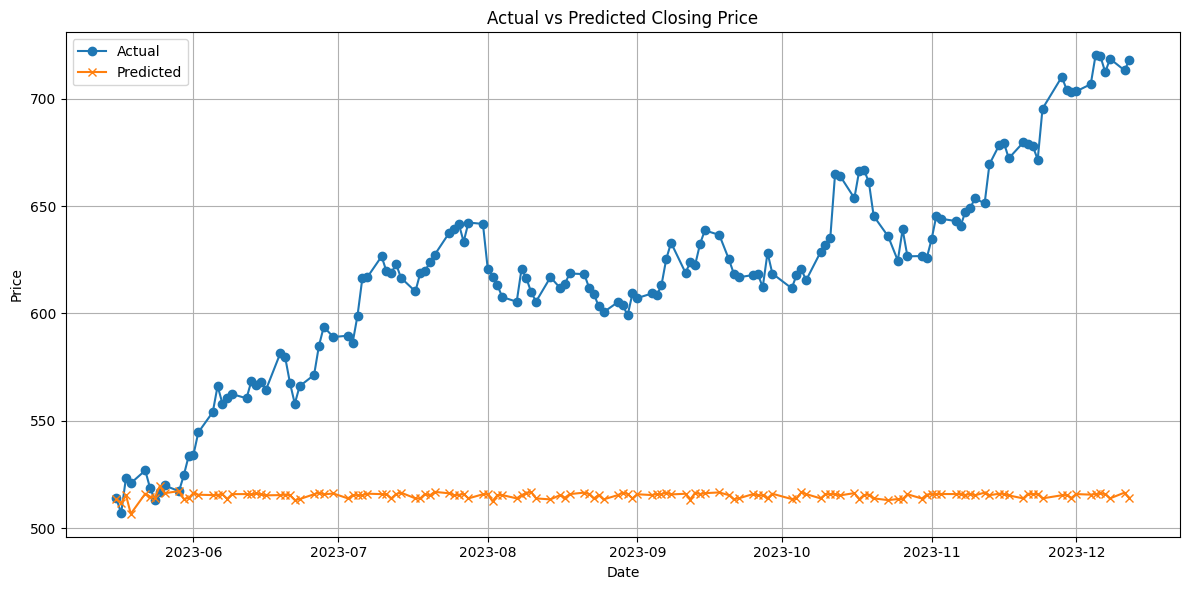

In [4]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# 1. Load the data
try:
    df = pd.read_csv("TAMO Historical Data.csv")
except FileNotFoundError:
    print("Error: File 'TAMO Historical Data.csv' not found. Please make sure the file is in the correct directory.")
    exit()
except Exception as e:
    print(f"An error occurred while loading the data: {e}")
    exit()

# 2. Data Preprocessing
try:
    # Convert 'Date' to datetime
    df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
    df = df.sort_values('Date')

    # Clean 'Vol.' column, handling errors and NaNs more robustly
    def convert_volume(vol):
        if isinstance(vol, str):
            vol = vol.upper()  # Simplify checks
            if 'M' in vol:
                return float(vol.replace('M', '')) * 1e6
            elif 'K' in vol:
                return float(vol.replace('K', '')) * 1e3
            else:
                try:
                    return float(vol) # attempt to convert directly to float
                except ValueError:
                    return np.nan
        elif pd.isna(vol):
            return np.nan
        else:
            return float(vol) # if it is already a float or int

    df['Volume'] = df['Vol.'].apply(convert_volume)

    # Clean 'Change %' column
    df['Change %'] = df['Change %'].astype(str).str.replace('%', '', regex=False)
    df['Change %'] = pd.to_numeric(df['Change %'], errors='coerce')

    # Create target variable: next day's Price
    df['Target'] = df['Price'].shift(-1)

    # Drop the last row with NaN target
    df = df.dropna(subset=['Target'])

    # Check for missing values in features
    features = ['Open', 'High', 'Low', 'Price', 'Volume', 'Change %']
    if df[features].isnull().any().any(): # check if any value in the selected features is null
        print("Warning: Missing values found in the following columns:")
        print(df[features].isnull().sum())
        # Handle missing values.  A simple approach is to fill with the mean:
        df[features] = df[features].fillna(df[features].mean())
        #  Another approach is to drop rows with missing values, but this can lead to data loss:
        # df.dropna(subset=features, inplace=True)

except KeyError as e:
    print(f"Error: Key not found: {e}.  Please ensure the CSV file contains the necessary columns.")
    exit()
except Exception as e:
    print(f"An error occurred during data preprocessing: {e}")
    exit()

# 3. Feature Engineering (Added Feature Importance)
features = ['Open', 'High', 'Low', 'Price', 'Volume', 'Change %']
X = df[features]
y = df['Target']

# 4. Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# 5. Train model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 6. Predict
y_pred = model.predict(X_test)

# 7. Evaluation
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print("R² Score:", r2)
print("MSE:", mse)

# 8. Feature Importance
importance = model.feature_importances_
feature_importance = pd.DataFrame({'Feature': features, 'Importance': importance})
feature_importance = feature_importance.sort_values('Importance', ascending=False)
print("\nFeature Importance:")
print(feature_importance)

# 9. Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(df['Date'].iloc[-len(y_test):].values, y_test.values, label='Actual', marker='o') # added date
plt.plot(df['Date'].iloc[-len(y_test):].values, y_pred, label='Predicted', marker='x') # added date
plt.title("Actual vs Predicted Closing Price")
plt.xlabel("Date") # changed label
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
